# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.1538856619999933
GPU (s):
0.09794350800007123
GPU speedup over CPU: 32x


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import os
from os.path import isfile
import tensorflow as tf
import keras
from keras.utils import np_utils
import itertools
import shutil
np.random.seed(42)
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
!unzip -o -q '/content/drive/My Drive/Dataset.zip'

warning [/content/drive/My Drive/Dataset.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/My Drive/Dataset.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #278362).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)
os.mkdir('all_images_dir/1')
os.mkdir('all_images_dir/0')

In [ ]:
cur_dir = '/content/Dataset'
patient_list = os.listdir(cur_dir)
all_images = '/content/all_images_dir'
for i in range(len(patient_list)):
  temp = cur_dir + '/'+ str(patient_list[i])
  try:
    path_0 = temp + '/0'
    path_1 = temp + '/1'
    file_list_0 = os.listdir(path_0)
    file_list_1 = os.listdir(path_1)

    for fname in file_list_0:
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_images_dir, '0', fname)
        shutil.copyfile(src, dst)

    for fname in file_list_1:
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_images_dir, '1', fname)
        shutil.copyfile(src, dst)
        
  except:
     print(temp, 'cannot be copied into proper folder')

In [ ]:
print('Total:', len(os.listdir('all_images_dir/1'))+len(os.listdir('all_images_dir/0')))
print('Positive:', len(os.listdir('all_images_dir/1')))
print('Negative:', len(os.listdir('all_images_dir/0')))

Total: 277524
Positive: 78786
Negative: 198738


In [ ]:
image_list_1 = os.listdir('all_images_dir/1')
df_data_1 = pd.DataFrame(image_list_1, columns=['image_id'])

image_list_0 = os.listdir('all_images_dir/0')
df_data_0 = pd.DataFrame(image_list_0, columns=['image_id'])

df_data = pd.concat([df_data_1, df_data_0])

In [ ]:
df_data.head()

,image_id
0,10264_idx5_x1401_y901_class1.png
1,16165_idx5_x1351_y1801_class1.png
2,12906_idx5_x2051_y1801_class1.png
3,8916_idx5_x451_y1551_class1.png
4,13687_idx5_x2551_y451_class1.png


In [ ]:
def extract_patient_id(x):
    a = x.split('_')
    patient_id = a[0]   
    return patient_id

def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    return target

df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head()

,image_id,patient_id,target
0,10264_idx5_x1401_y901_class1.png,10264,1
1,16165_idx5_x1351_y1801_class1.png,16165,1
2,12906_idx5_x2051_y1801_class1.png,12906,1
3,8916_idx5_x451_y1551_class1.png,8916,1
4,13687_idx5_x2551_y451_class1.png,13687,1


In [ ]:
from sklearn.model_selection import train_test_split

y = df_data['target']

_, df_test = train_test_split(df_data, test_size=0.03603, random_state=42, stratify=y)

_, df_val = train_test_split(df_data, test_size=0.0036025, random_state=42, stratify=y)

print('Valid:', df_val.shape[0])
print('Test:', df_test.shape[0])

Valid: 1000
Test: 10000


In [ ]:
df_val.head()

,image_id,patient_id,target
121626,13022_idx5_x1051_y1651_class0.png,13022,0
194027,13400_idx5_x1501_y1751_class0.png,13400,0
123961,10260_idx5_x251_y801_class0.png,10260,0
21361,10302_idx5_x2051_y1351_class1.png,10302,1
56886,13688_idx5_x251_y651_class0.png,13688,0


In [ ]:
def identify_train_val_and_test_rows(x):
    val_list = list(df_val['image_id'])
    test_list = list(df_test['image_id'])
    
    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'

df_data['train_or_val_or_test'] = df_data['image_id']
df_data['train_or_val_or_test'] = df_data['train_or_val_or_test'].apply(identify_train_val_and_test_rows)
   
df_train = df_data[df_data['train_or_val_or_test'] == 'train']
print('Train:', len(df_train))
print('Valid:', len(df_val))
print('Test:', len(df_test))

Train: 267524
Valid: 1000
Test: 10000


In [ ]:
train_dir = os.path.join('train_dir')
os.mkdir(train_dir)

val_dir = os.path.join('val_dir')
os.mkdir(val_dir)

test_dir = os.path.join('test_dir')
os.mkdir(test_dir)

os.mkdir(os.path.join(train_dir, '1'))
os.mkdir(os.path.join(train_dir, '0'))

os.mkdir(os.path.join(val_dir, '1'))
os.mkdir(os.path.join(val_dir, '0'))

os.mkdir(os.path.join(test_dir, '1'))
os.mkdir(os.path.join(test_dir, '0'))

In [ ]:
df_data.set_index('image_id', inplace=True)
df_data.head()

,patient_id,target,train_or_val_or_test
image_id,,,
10264_idx5_x1401_y901_class1.png,10264,1,train
16165_idx5_x1351_y1801_class1.png,16165,1,train
12906_idx5_x2051_y1801_class1.png,12906,1,train
8916_idx5_x451_y1551_class1.png,8916,1,train
13687_idx5_x2551_y451_class1.png,13687,1,train


In [ ]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])

for image in train_list:    
    pat_id = df_data.loc[image,'patient_id']
    label = df_data.loc[image,'target']
    src = '/content/all_images_dir/'+label +'/' + image
    dst = os.path.join('/content/train_dir', label, image)
    shutil.copyfile(src, dst)

for image in val_list:  
    pat_id = df_data.loc[image,'patient_id']
    label = df_data.loc[image,'target']
    src = '/content/all_images_dir/'+label+ '/' + image
    dst = os.path.join('/content/val_dir', label, image)
    shutil.copyfile(src, dst)
    
for image in test_list:  
    pat_id = df_data.loc[image,'patient_id']
    label = df_data.loc[image,'target']
    src = '/content/all_images_dir/'+label+ '/' + image
    dst = os.path.join('/content/test_dir', label, image)
    shutil.copyfile(src, dst)

In [ ]:
print('Train Total:', len(os.listdir('train_dir/1'))+len(os.listdir('train_dir/0')))
print('Valid Total:', len(os.listdir('val_dir/1'))+len(os.listdir('val_dir/0')))
print('Test Total:', len(os.listdir('test_dir/1'))+len(os.listdir('test_dir/0')), '\n')

print('Train Negative:', len(os.listdir('train_dir/0')))
print('Train Positive:', len(os.listdir('train_dir/1')), '\n')

print('Valid Negative:', len(os.listdir('val_dir/0')))
print('Valid Positive:', len(os.listdir('val_dir/1')), '\n')

print('Test Negative:', len(os.listdir('test_dir/0')))
print('Test Positive:', len(os.listdir('test_dir/1')))

Train Total: 267524
Valid Total: 1000
Test Total: 10000 

Train Negative: 191577
Train Positive: 75947 

Valid Negative: 716
Valid Positive: 284 

Test Negative: 7161
Test Positive: 2839


In [ ]:
train_path = '/content/train_dir'
valid_path = '/content/val_dir'
test_path = '/content/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 500
val_batch_size = 500

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
print(train_steps)
print(val_steps)

536.0
2.0


In [ ]:
image_size = 50

from keras.preprocessing.image import ImageDataGenerator

aug_dir = 'aug_dir'
os.mkdir(aug_dir)
img_dir = os.path.join(aug_dir, 'img_dir')
os.mkdir(img_dir)
img_list = os.listdir('/content/train_dir/1')

for fname in img_list:
    src = os.path.join('/content/train_dir/1', fname)
    dst = os.path.join(img_dir, fname)
    shutil.copyfile(src, dst)

path = '/content/aug_dir'
save_path = '/content/train_dir/1'

datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.125,
    height_shift_range=0.125,
    zoom_range=[1.2, 1.325],
    fill_mode='reflect')

batch_size = 25

aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size)

num_aug_images_wanted = len(os.listdir('train_dir/0')) # total number of images wanted in each class

num_files = len(os.listdir(img_dir))
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))
#print(num_aug_images_wanted,num_files,num_batches)
for i in range(0, num_batches):
  next(aug_datagen)

shutil.rmtree('aug_dir')

Found 191594 images belonging to 1 classes.
191577 191594 0


In [ ]:
  class_weights={
    0: 1.0,  
    1: 1.0,  
}

print('Train Total:', len(os.listdir('train_dir/1'))+len(os.listdir('train_dir/0')))
print('Train Negative:', len(os.listdir('train_dir/0')))
print('Train Positive:', len(os.listdir('train_dir/1')), '\n')
print("Tran")

Train Total: 383171
Train Negative: 191577
Train Positive: 191594 



In [ ]:
datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input, 
                             horizontal_flip=True,
                             vertical_flip=True)

train_batches_bench = datagen.flow_from_directory(train_path, 
                                                  target_size=(image_size, image_size),
                                                  batch_size=train_batch_size)

valid_batches_bench = datagen.flow_from_directory(valid_path,  
                                                  target_size=(image_size, image_size),
                                                  batch_size=val_batch_size)

test_batches_bench = datagen.flow_from_directory(test_path,  
                                                 target_size=(image_size, image_size),
                                                 batch_size=1,
                                                 shuffle=False)

Found 383171 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, Activation, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as K

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32,(3, 3),activation='relu',input_shape=(50,50,3),padding='Same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu',padding='Same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(32,(3, 3),activation='relu',padding='Same'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu',padding='Same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 32)        18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)       

In [ ]:
from keras import metrics
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpointer_model = ModelCheckpoint(filepath='/content/drive/My Drive/model_eight_epochs.hdf5', verbose=1, save_best_only=True)
history_model = model.fit_generator(train_batches_bench, 
                                            steps_per_epoch=train_steps, 
                                            class_weight=class_weights,
                                            validation_data=valid_batches_bench,
                                            validation_steps=val_steps,
                                            callbacks=[checkpointer_model], 
                                            epochs=8, 
                                            verbose=1)

Epoch 1/8
536/536 [==============================] - 172s 320ms/step - loss: 0.3648 - accuracy: 0.8703 - val_loss: 0.3998 - val_accuracy: 0.8490

Epoch 00001: val_loss improved from inf to 0.39982, saving model to /content/drive/My Drive/model_eight_epochs.hdf5
Epoch 2/8
536/536 [==============================] - 151s 283ms/step - loss: 0.2249 - accuracy: 0.9058 - val_loss: 0.3810 - val_accuracy: 0.8290

Epoch 00002: val_loss improved from 0.39982 to 0.38099, saving model to /content/drive/My Drive/model_eight_epochs.hdf5
Epoch 3/8
536/536 [==============================] - 114s 213ms/step - loss: 0.2112 - accuracy: 0.9121 - val_loss: 0.3125 - val_accuracy: 0.8580

Epoch 00003: val_loss improved from 0.38099 to 0.31247, saving model to /content/drive/My Drive/model_eight_epochs.hdf5
Epoch 4/8
536/536 [==============================] - 100s 186ms/step - loss: 0.2016 - accuracy: 0.9163 - val_loss: 0.3349 - val_accuracy: 0.8660

Epoch 00004: val_loss did not improve from 0.31247
Epoch 5/8

In [ ]:
import matplotlib.patches as mpatches

def plot_training(history):
  
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs,acc, 'b')
    plt.plot(epochs,val_acc, 'r')
    redp = mpatches.Patch(color='blue', label='Training Accuracy')
    bluep = mpatches.Patch(color='red', label='Val Accuracy')
    plt.legend(handles=[redp,bluep])
    plt.title("Training & Validation Accuracy")
    
    plt.figure()
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    redp = mpatches.Patch(color='blue', label='Training loss')
    bluep = mpatches.Patch(color='red', label='Val loss')
    plt.legend(handles=[redp,bluep])
    plt.title("Training & Validation Loss")
    
    plt.show()

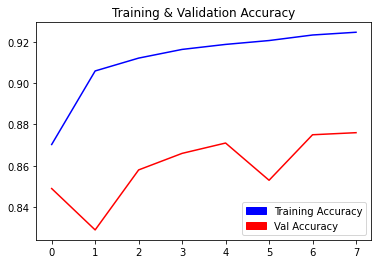

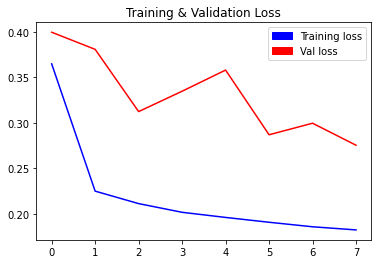

In [ ]:
plot_training(model)

In [ ]:
preds = model.predict_generator(test_batches_bench, steps=len(df_test), verbose=1)

NameError: ignored

In [ ]:
y_pred = np.argmax(preds, axis=1)
y_true = test_batches_bench.classes

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%')

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 82.18%
Predicted Positive Probability: 17.82%


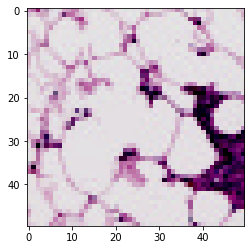

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC positive
Predicted Negative Probability: 30.19%
Predicted Positive Probability: 69.81%


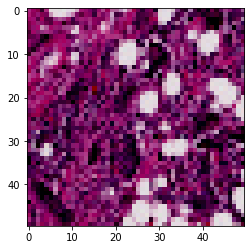

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 99.91%
Predicted Positive Probability: 0.09%


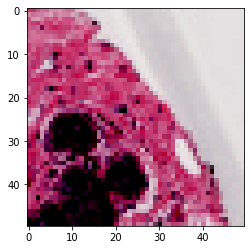

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 98.62%
Predicted Positive Probability: 1.38%


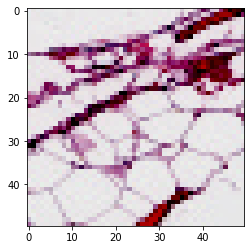

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 93.80%
Predicted Positive Probability: 6.20%


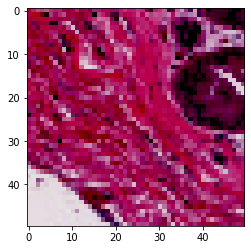

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 95.37%
Predicted Positive Probability: 4.63%


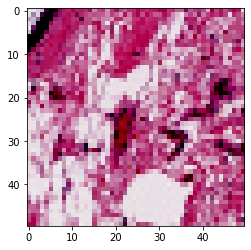

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 99.84%
Predicted Positive Probability: 0.16%


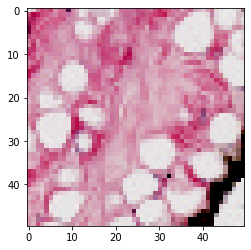

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 88.97%
Predicted Positive Probability: 11.03%


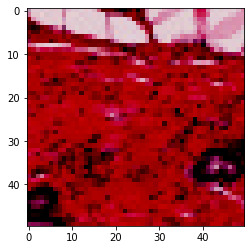

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IDC negative
Predicted Negative Probability: 97.44%
Predicted Positive Probability: 2.56%


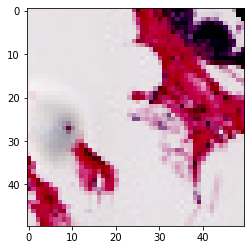

In [ ]:
x, y = valid_batches_bench.next()
for i in range(1,10):
  
  image = x[i]
  label = y[i]
  
  if np.argmax(label, axis=0) == 0:
      print('IDC negative')
  if np.argmax(label, axis=0) == 1:
    print('IDC positive')

  prob = model.predict(image.reshape(1,50,50,3))
  for a in prob:
    for b in a:
      print(f'Predicted Negative Probability: {(b*100):1.2f}%')
      print(f'Predicted Positive Probability: {(1-b)*100:1.2f}%')
      break

  plt.imshow(image)
  plt.show()